# Regularization Techniques: Lasso and Ridge Regression

<img src = 'https://drive.google.com/uc?id=1WC7SSdfFseYRgmZ6lbodv898zi2nquJ0' width = 80%>

# Introduction and Dataset

## Background

This tutorial will explore Lasso and Ridge regression methods to model different response variables that are commonly modeled in forestry. These include quadratic mean diameter (QMD), aboveground biomass (AGB), and basal area (BA). The tutorial will employ a suite of input features (i.e., predictor variables) used to estimate the response variables. 

## Tutorial goals

**Goal 1: Model  using ridge and lasso regression**

-----

**Notes:**

- *notes here*

## Data

*data description here*

Please refer to the README on the main GitHub page for a detailed description of each file.


## Packages

*relevant packages here*




# Install and load packages

**Uncomment the cell below to install required packages**

In [1]:
# !pip install pandas==2.2.2
# !pip install geopandas==1.0.1
# !pip install matplotlib==3.10.1
# !pip install rioxarray==0.19.0
# !pip install laspy[lazrs]==2.5.4

In [2]:
import os
import pandas as pd
import geopandas as gpd
import rioxarray as rio
from math import sqrt, pi
import matplotlib.pyplot as plt

# Download data

In [3]:
# Download the data if it does not yet exist
if not os.path.exists("data"):
  !gdown 1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2
  !unzip prf_data.zip -d data/
  os.remove("prf_data.zip")
else:
  print("Data has already been downloaded.")

os.listdir("data")

Data has already been downloaded.


['boundary.gpkg',
 'forest_point_cloud.las',
 'forest_point_cloud_footprint.gpkg',
 'original',
 'p99.tif',
 'petawawa_s2_2018.tif',
 'petawawa_s2_2024.tif',
 'plots.gpkg',
 'trees.csv',
 'water.gpkg']

# Preprocessing

Before we can begin with ridge and lasso regression, we must first preprocess the data so it is analysis ready. The following code blocks will prepare both the response variables (QMD, AGB, BA) in addition to predictor variables (99th height percentile and spectral indices).

In [4]:

trees_df = gpd.read_file(r'data/trees.csv')

plots_gdf = gpd.read_file(r'data/plots.gpkg')


In [5]:
# Ensure multiple columns in trees df are numeric
cols_to_convert = ['biomass', 'height', 'baha', 'DBH']
for col in cols_to_convert:
    trees_df[col] = pd.to_numeric(trees_df[col])

trees_df

,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size
0,PRF001,24.0,White pine,P,D,10.1,,1.0,11.552521,0.128190,N,0.0,0.7087347141,393.396400,Poles
1,PRF001,46.0,White pine,P,D,9.9,,2.0,11.422529,0.123163,N,0.0,0.6732544319,375.305379,Poles
2,PRF001,20.0,Red pine,N,L,67.5,D,,33.900000,5.725566,Y,77.327438489,79.482658012,39691.639950,Large
3,PRF001,50.0,Red pine,N,L,57.9,D,,32.528851,4.212773,Y,56.444280856,58.117291913,28251.255888,Large
4,PRF001,10.0,White pine,N,L,55.9,D,,33.000000,3.926761,Y,48.008649036,49.833742798,24501.838779,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12585,PRF334,,Sugar Maple,N,L,3.7,,,8.893640,0.215043,N,0.0,0.8585643577,851.191939,Under
12586,PRF334,,Sugar Maple,N,L,3.3,,,8.500000,0.171060,N,0.0,0.6538680809,659.084439,Under
12587,PRF334,,Sugar Maple,N,L,3.2,,,8.395967,0.160850,N,0.0,0.607492501,615.333049,Under
12588,PRF334,,Sugar Maple,N,L,3.0,,,7.400000,0.141372,N,0.0,0.4696555303,521.064025,Under


In [6]:
# Check the range of various tree attributes
trees_df.describe()

,DBH,height,baha,biomass
count,12590.000000,12590.000000,12590.000000,12342.000000
mean,17.622415,15.883219,0.602011,3286.085532
std,11.559345,6.713323,0.895101,6305.457552
min,2.500000,1.301584,0.070686,138.409692
25%,10.600000,11.531384,0.174975,634.448847
50%,14.500000,14.907205,0.309749,1266.913205
75%,21.100000,19.398785,0.623451,2800.442589
max,97.500000,50.300000,11.945934,89100.864298


## Quadratic Mean Diameter

Quadratic Mean Diameter (QMD) is a common stand level attribute that is modeled in forestry. QMD is often prefered over the arithmetic mean in forestry because it gives greater weight to larger trees. This is relevant for several reasons, primarily though because the wood from larger trees is more valuable.

QMD also is relevant for understanding forest ecology among other applications.

              qmd
count  249.000000
mean    22.515733
std      7.292152
min      9.487689
25%     17.508306
50%     20.996809
75%     25.918597
max     58.166457


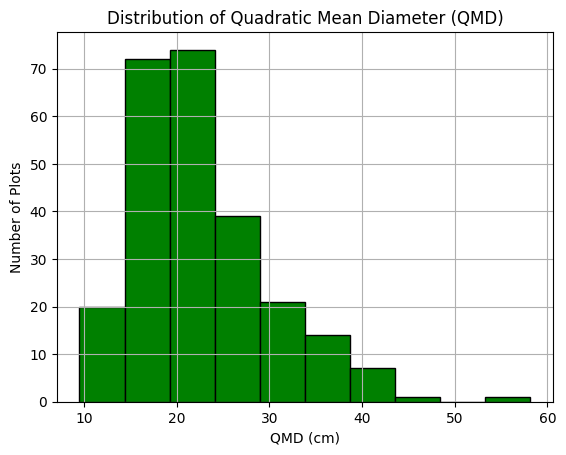

In [7]:
# Calculate the Quadratic Mean Diameter (QMD)
qmd_df = (
    trees_df
    .groupby('PlotName')
    .agg(
        n_trees=('DBH', 'count'),
        sum_squares=('DBH', lambda x: (x**2).sum())
    )
    .assign(qmd=lambda df: (df['sum_squares'] / df['n_trees']).apply(sqrt))
    .reset_index()[['PlotName', 'qmd']]
)

print(qmd_df.describe())

ax = qmd_df['qmd'].hist(edgecolor='black', color='green')
ax.set_xlabel('QMD (cm)')
ax.set_ylabel('Number of Plots')
ax.set_title('Distribution of Quadratic Mean Diameter (QMD)')
plt.show()

## Aboveground Biomass (AGB)

Forest aboveground biomass (AGB) is another very common stand attribute to model. Biomass is defined as the living organic materials comprising trees including wood, bark, branches, foliage, etc. AGB is modeled for many different reasons. One relevant application of AGB modelling is for forest carbon projects, since forest aboveground carbon is typically estimated to be ~50% of AGB.

We can calculate plot-level AGB by summing the AGB of all trees in a plot, and then dividing that by the plot area. This is performed in the code below.

Area of each plot in hectares: 0.0625 ha
       biomass_Mg_total  biomass_Mg_ha
count        249.000000     249.000000
mean          10.179937     162.878987
std            5.571596      89.145529
min            0.146435       2.342960
25%            6.375452     102.007230
50%            9.263491     148.215860
75%           12.238090     195.809442
max           35.127161     562.034569


Text(0.5, 1.0, 'Distribution of Aboveground Biomass')

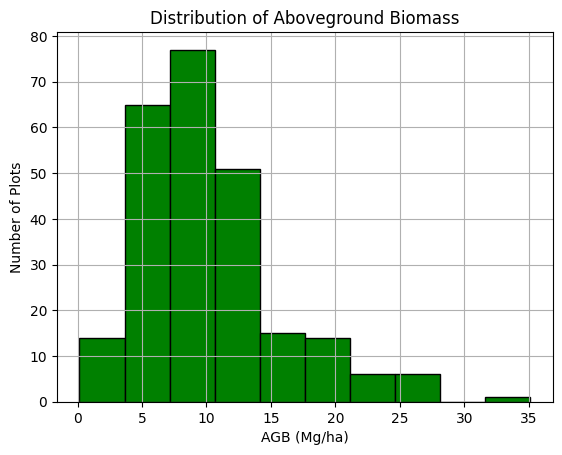

In [8]:
# Note that each plot has a radius of 14.1m (625m^2) 
# We need to convert to hectares, since this is the most common areal unit in forestry.
# There are 10000 m^2 in a hectare, so we divide by 10000.

plot_area_m2 = 625

plot_area_ha = plot_area_m2 / 10000

print(f"Area of each plot in hectares: {plot_area_ha} ha")

# Convert tree-level biomass from Kg/ha to Kg, and then to Mg (tonnes).
trees_df['biomass_kg'] = trees_df['biomass'] * plot_area_ha
trees_df['biomass_Mg'] = trees_df['biomass_kg'] / 1000  

biomass_df = (trees_df.groupby('PlotName').
                    agg(biomass_Mg_total=('biomass_Mg', 'sum')).
                    assign(biomass_Mg_ha=lambda x: x['biomass_Mg_total'] / plot_area_ha))

# Summarize biomass
print(biomass_df.describe())

ax = biomass_df['biomass_Mg_total'].hist(edgecolor='black', color='green')
ax.set_xlabel('AGB (Mg/ha)')
ax.set_ylabel('Number of Plots')
ax.set_title('Distribution of Aboveground Biomass')

 ## Basal Area


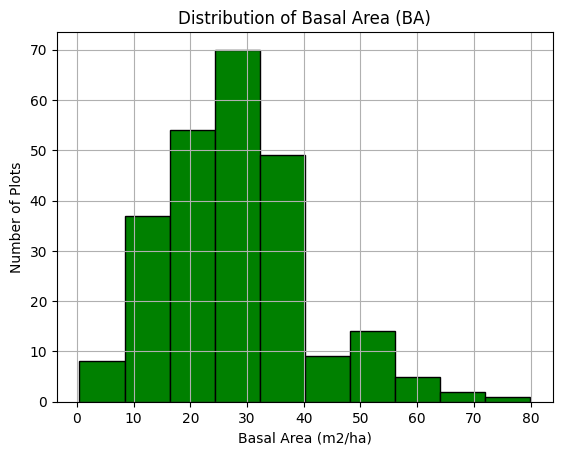

In [9]:
def get_ba(dbh):
    return ((dbh / 2) ** 2) * pi

trees_df = (trees_df
            .assign(ba_cm2=lambda x: get_ba(x['DBH']))
            .assign(ba_m2=lambda x: x['ba_cm2'] / 10000)
            .groupby('PlotName')
            .agg(total_ba_m2_ha=('ba_m2', 'sum'))
            .assign(ba_m2_ha=lambda x: x['total_ba_m2_ha'] / plot_area_ha)
            .reset_index())

biomass_df.describe()

ax = trees_df['ba_m2_ha'].hist(edgecolor='black', color='green')
ax.set_xlabel('Basal Area (m2/ha)')
ax.set_ylabel('Number of Plots')
ax.set_title('Distribution of Basal Area (BA)')
plt.show()

## LiDAR-Derived 99th Height Percentile

We load the 9th height percentile raster as an xarray dataset. xarray is similar to numpy arrays, but with added attributes and functionality. For example, xarrays can contain spatial coordinate reference systems (CRS).

In [10]:
# Read the 99th height percentile raster
p99 = rio.open_rasterio(r'data/p99.tif')
p99

<xarray.DataArray (band: 1, y: 366, x: 746)> Size: 1MB
[273036 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 6kB 2.974e+05 2.974e+05 ... 3.16e+05 3.16e+05
  * y            (y) float64 3kB 5.099e+06 5.099e+06 ... 5.09e+06 5.09e+06
    spatial_ref  int64 8B 0
Attributes:
    STATISTICS_MAXIMUM:      45.569999694824
    STATISTICS_MEAN:         25.239122333602
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       5.3449476495645
    AREA_OR_POINT:           Area
    _FillValue:              -3.4028235e+38
    scale_factor:            1.0
    add_offset:              0.0

In [11]:
# Ensure that raster and plot coordinates are in the same CRS
assert plots_gdf.crs == p99.rio.crs, "CRS mismatch between plots and raster data."

In [12]:
# Get list of plot coordinates tuples
plot_coords = [(geom.x, geom.y) for geom in plots_gdf.geometry]

# Extract the 99th percentile height at the plot coordinates
plots_gdf['p99'] = [p99.sel(x=c[0], y=c[1], method="nearest").values[0] for c in plot_coords]

plots_gdf

,Plot,Date,Northing,Easting,Source,geometry,p99
0,PRF208R,August 7 2018,5098426.096,312924.933,Topcon Hiper V PPP,POINT Z (312924.734 5098427.112 0),4.690000
1,PRF320,November 23 2018,5098579.361,312625.094,Topcon HiperSR PPP,POINT Z (312624.895 5098580.377 0),22.100000
2,PRF016,August 8 2018,5096992.483,313662.119,Topcon Hiper V PPP,POINT Z (313661.921 5096993.499 0),19.920000
3,PRF017,August 14 2018,5096896.098,313863.850,Topcon Hiper V PPP,POINT Z (313863.652 5096897.114 0),22.359999
4,PRF018,August 8 2018,5097138.299,313692.563,Topcon Hiper V PPP,POINT Z (313692.365 5097139.315 0),20.180000
...,...,...,...,...,...,...,...
244,PRF187,November 22 2018,5091476.078,308950.650,Topcon Hiper V PPP,POINT Z (308950.451 5091477.093 0),28.230000
245,PRF209,October 19 2018,5091851.419,312997.322,Topcon Hiper V PPP,POINT Z (312997.124 5091852.434 0),16.930000
246,PRF214,October 6 2018,5091627.257,312973.063,Topcon Hiper V PPP,POINT Z (312972.865 5091628.272 0),33.680000
247,PRF149,October 25 2018,5090277.081,301422.935,Topcon HiperSR PPP,POINT Z (301422.735 5090278.095 0),28.849998


In [13]:
plots_gdf_na = plots_gdf[plots_gdf['p99'].isna()]
